# Country Development Clustering: Identifying Priority Nations for Aid  
## Second Notebook: Objective 

Building upon the exploratory insights from the first notebook, this second part focuses on **data preparation, dimensionality reduction, and clustering** to uncover meaningful structural patterns among countries.  
The goal is to prepare the data for modeling, reduce redundancy, and identify groups of nations that share similar socio-economic and health characteristics.

In this notebook, we will:

- **Perform data transformations** (scaling and normalization) to ensure that all features contribute equally to distance-based algorithms.  
- **Apply Principal Component Analysis (PCA)** to reduce dimensionality while retaining the most significant variance in the dataset.  
- **Implement and compare multiple clustering algorithms**, including:
  - *K-Means* — for a baseline partitioning approach.  
  - *Hierarchical Clustering* — to reveal nested relationships between countries.  
  - *DBSCAN* — to identify dense regions and potential outliers.

The **interpretation of clusters** and **formulation of actionable insights** for HELP International will be presented in the **third notebook**.

**Author:** J-F Jutras  
**Date:** November 2025  
**Dataset:** *Unsupervised Learning on Country Data – Kaggle*



## 2.1-Data Loading

The dataset is retrieved directly from Kaggle using the `kagglehub` library. This ensures the analysis remains reproducible and uses the latest available version.

In [1]:
import kagglehub
import pandas as pd
import os

path = kagglehub.dataset_download("rohan0301/unsupervised-learning-on-country-data")

#Load dataset directly from Kaggle cache
df = pd.read_csv(f"{path}/Country-data.csv")

#Recreate a copy with exports_amount, imports_amount and health_amount and drop exports, 
#imports and health
df2 = df.copy()

df2['exports_amount'] = df2['exports'] / 100 * df2['gdpp']
df2['imports_amount'] = df2['imports'] / 100 * df2['gdpp']
df2['health_amount'] = df2['health'] / 100 * df2['gdpp']

df2 = df2.drop(columns = ['exports', 'imports', 'health'])

## 2.2-Data Preparation

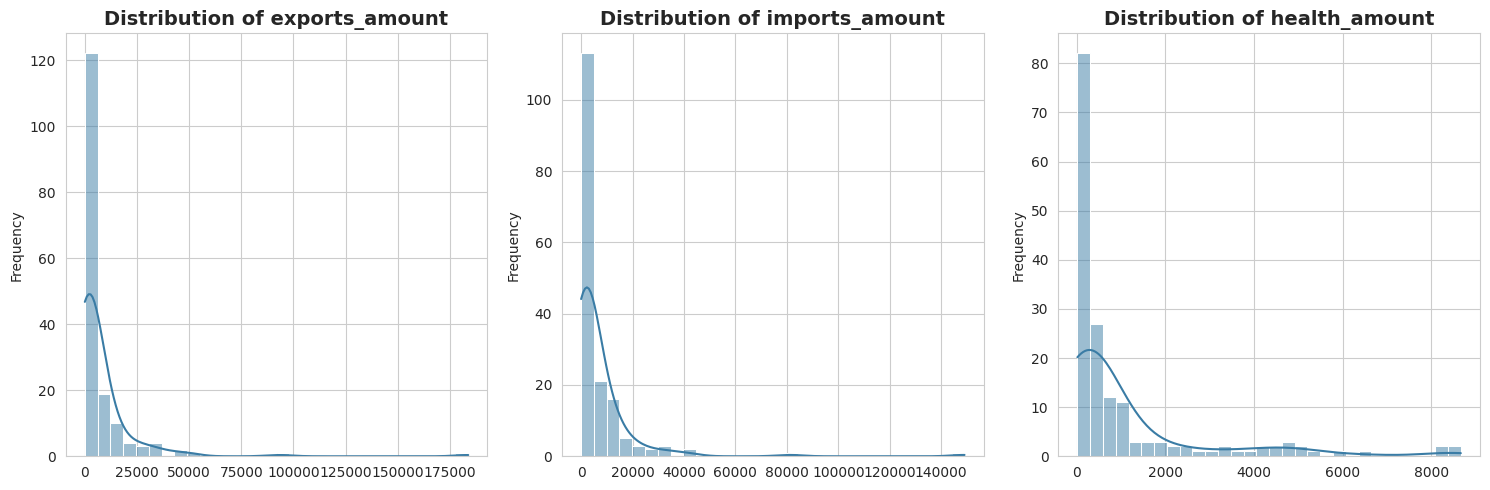

In [2]:
#Analyze distributions of all numerical features in df2, including the '_amount' columns
#Note: In the first notebook we focused on ratios and did not examine exports_amount, 
#imports_amount, or health_amount. Here, we check their distributions to determine 
#if any transformations (e.g., log) are needed before PCA or clustering.

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#Temporarily ignore warnings to keep visualization clean
import warnings
warnings.filterwarnings("ignore")

#Columns of interest
amount_cols = ['exports_amount', 'imports_amount', 'health_amount']

# Set up the figure
fig = plt.figure(figsize = (15, 5))
sns.set_style("whitegrid")

# Loop through each column to plot its histogram with KDE
for i, col in enumerate(amount_cols):
    ax = fig.add_subplot(1, 3, i + 1)
    sns.histplot(df2[col], kde = True, bins = 30, color = "#3a7ca5", ax = ax)
    ax.set_title(f'Distribution of {col}', fontsize = 14, fontweight = 'bold')
    ax.set_xlabel('')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

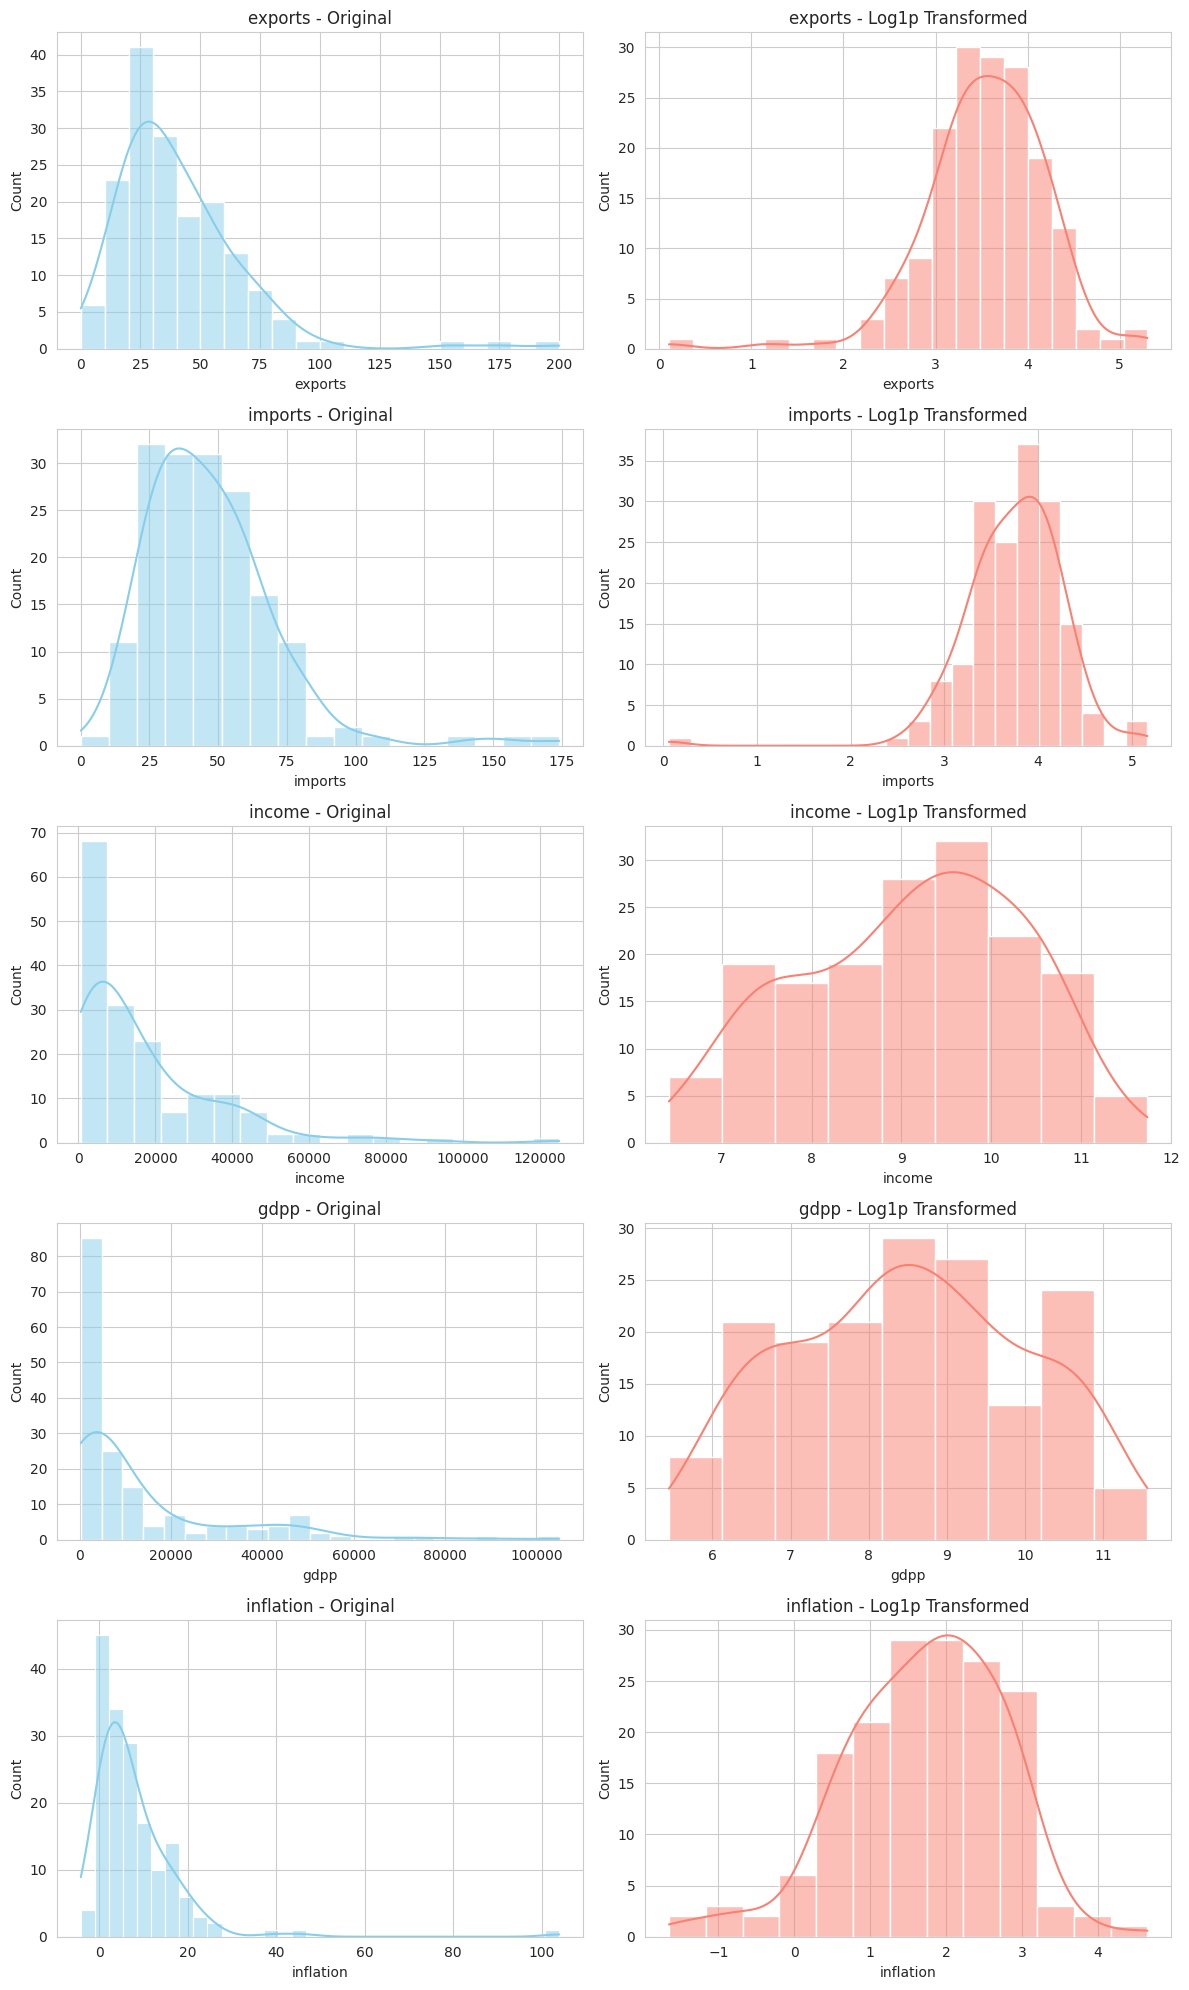

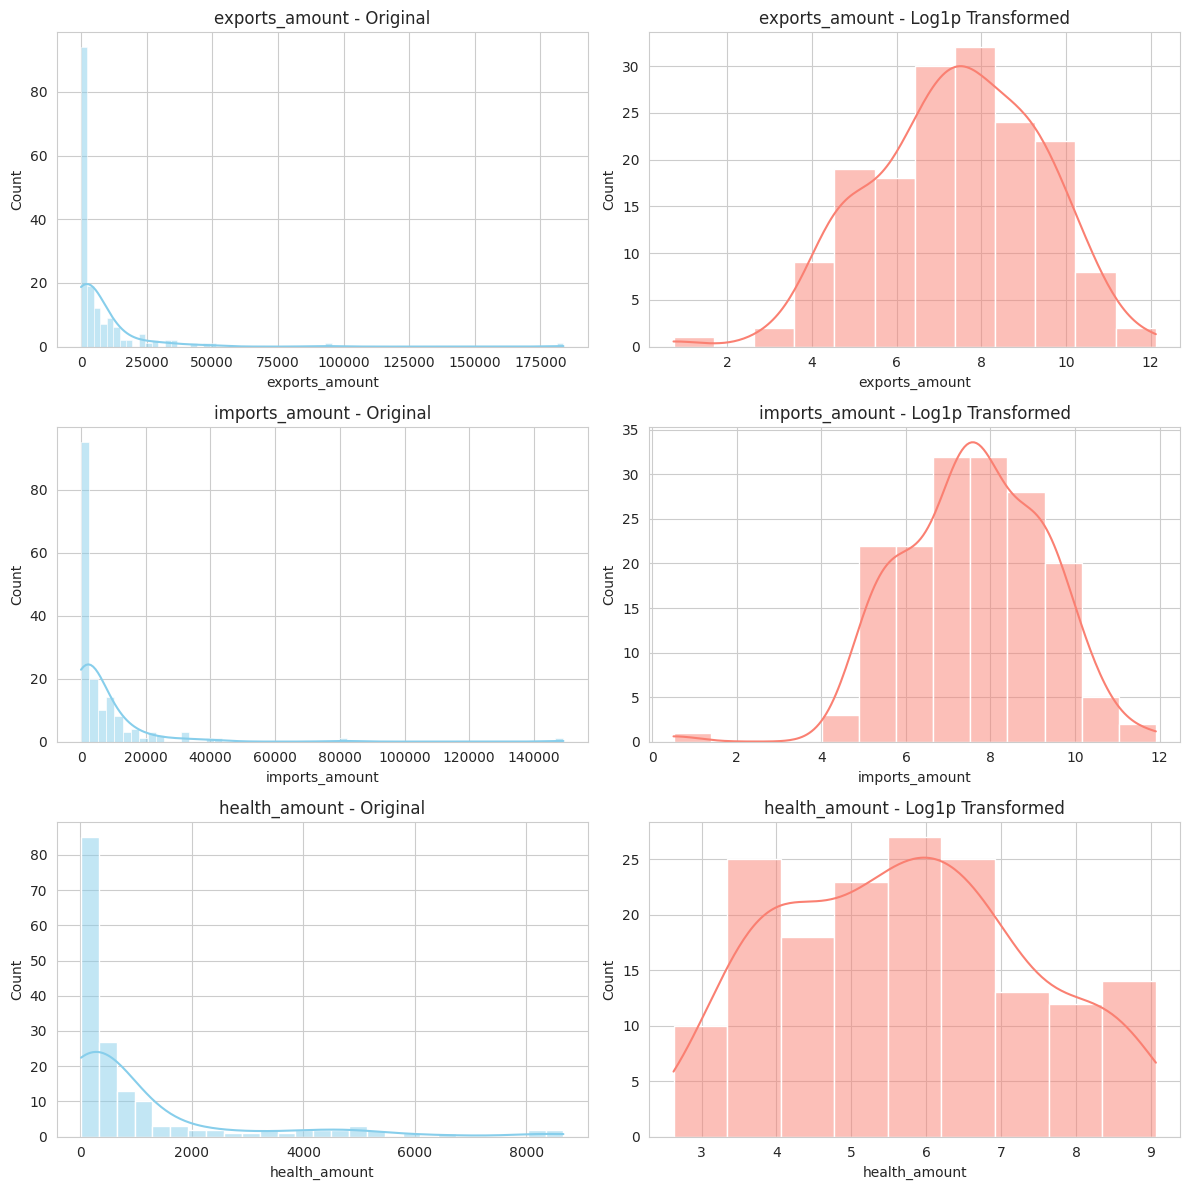

In [3]:
#Applying logarithmic transformations only to highly skewed variables helps stabilize variance and
#reduces the influence of extreme outliers. Distance-based algorithms like PCA and K-Means clustering
#are sensitive to extreme values, so log-transform ensures that clusters are not dominated by a few
#wealthy or extreme countries. For variables that can have negative values (like 'inflation'), we 
#preserve the sign by taking log(1 + abs(x)) and then multiplying by the sign. This allows us
#to maintain interpretability while still reducing skewness.

#Define skewed variables for transformation
df_skewed = ['exports', 'imports', 'income', 'gdpp', 'inflation']
df2_skewed = ['exports_amount', 'imports_amount', 'health_amount']

#Create copies of original datasets to avoid overwriting
df_log = df.copy()
df2_log = df2.copy()

#Apply robust log-transform to df_skewed variables
for col in df_skewed:
    #Check if the column has negative values
    if (df_log[col] < 0).any():
        #Preserve the sign for negative values (e.g., deflation)
        df_log[col] = np.sign(df_log[col]) * np.log1p(np.abs(df_log[col]))
    else:
        # Standard log1p for non-negative values
        df_log[col] = np.log1p(df_log[col])

#Apply standard log1p transform to df2_skewed variables (all positive)
df2_log[df2_skewed] = df2_log[df2_skewed].apply(np.log1p)

#Visualize Distributions Before and After Transformation (df)
fig, axes = plt.subplots(len(df_skewed), 2, figsize=(12, 4*len(df_skewed)))
for i, col in enumerate(df_skewed):
    #Original distribution
    sns.histplot(df[col], kde=True, ax=axes[i,0], color='skyblue')
    axes[i,0].set_title(f'{col} - Original')
    #Log-transformed distribution
    sns.histplot(df_log[col], kde=True, ax=axes[i,1], color='salmon')
    axes[i,1].set_title(f'{col} - Log1p Transformed')

plt.tight_layout()
plt.show()

#Visualize Distributions Before and After Transformation (df2)
fig, axes = plt.subplots(len(df2_skewed), 2, figsize=(12, 4*len(df2_skewed)))
for i, col in enumerate(df2_skewed):
    sns.histplot(df2[col], kde=True, ax=axes[i,0], color='skyblue')
    axes[i,0].set_title(f'{col} - Original')
    sns.histplot(df2_log[col], kde=True, ax=axes[i,1], color='salmon')
    axes[i,1].set_title(f'{col} - Log1p Transformed')

plt.tight_layout()
plt.show()

In [4]:
#Display descriptive stats after log-transform
print("Summary statistics for df (ratios) after log1p:")
display(df_log.describe().T)

print("\nSummary statistics for df2 (amounts) after log1p:")
display(df2_log.describe().T)

Summary statistics for df (ratios) after log1p:


,count,mean,std,min,25%,50%,75%,max
child_mort,167.0,38.270060,40.328931,2.600000,8.250000,19.300000,62.100000,208.000000
exports,167.0,3.553176,0.656774,0.103459,3.210844,3.583519,3.957951,5.303305
health,167.0,6.815689,2.746837,1.810000,4.920000,6.320000,8.600000,17.900000
imports,167.0,3.746839,0.540116,0.063820,3.440398,3.790985,4.090166,5.164786
income,167.0,9.115631,1.228722,6.413459,8.118495,9.206433,10.034550,11.736077
inflation,167.0,1.710823,1.031810,-1.650580,1.033083,1.854734,2.463772,4.653960
life_expec,167.0,70.555689,8.893172,32.100000,65.300000,73.100000,76.800000,82.800000
total_fer,167.0,2.947964,1.513848,1.150000,1.795000,2.410000,3.880000,7.490000
gdpp,167.0,8.500171,1.499398,5.446737,7.193573,8.446985,9.549682,11.561725



Summary statistics for df2 (amounts) after log1p:


,count,mean,std,min,25%,50%,75%,max
child_mort,167.0,38.270060,40.328931,2.600000,8.250000,19.300000,62.100000,208.000000
income,167.0,17144.688623,19278.067698,609.000000,3355.000000,9960.000000,22800.000000,125000.000000
inflation,167.0,7.781832,10.570704,-4.210000,1.810000,5.390000,10.750000,104.000000
life_expec,167.0,70.555689,8.893172,32.100000,65.300000,73.100000,76.800000,82.800000
total_fer,167.0,2.947964,1.513848,1.150000,1.795000,2.410000,3.880000,7.490000
gdpp,167.0,12964.155689,18328.704809,231.000000,1330.000000,4660.000000,14050.000000,105000.000000
exports_amount,167.0,7.405192,1.940088,0.730886,6.104986,7.483492,8.889881,12.121337
imports_amount,167.0,7.605692,1.658890,0.501437,6.461519,7.623925,8.951603,11.912379
health_amount,167.0,5.738934,1.641001,2.626204,4.375990,5.777299,6.885302,9.067001


### Logarithmic Transformation of Highly Skewed Variables

We applied logarithmic (`log1p`) transformations to the most skewed variables in both datasets to stabilize variance and reduce the influence of extreme outliers.  

- **Ratios dataset (`df`)**: `exports`, `imports`, `income`, `gdpp`, and `inflation` were transformed. For variables like `inflation` that can have negative values (representing economic contraction), we preserved the sign by applying `log(1 + |x|) * sign(x)`.  
- **Amounts dataset (`df2`)**: `exports_amount`, `imports_amount`, and `health_amount` were transformed. These variables are strictly positive, so standard `log1p` was used.  

These transformations help ensure that distance-based algorithms such as PCA and K-Means clustering are not dominated by a few extreme or wealthy countries, resulting in **more balanced, reliable, and interpretable clusters**. Additionally, all original data points, including negative values and economic extremes, are preserved.

In [5]:
#Standardizing features ensures that variables with different scales contribute equally 
#to PCA and clustering. After log-transforming skewed variables, this prevents high-magnitude 
#indicators like GDP or trade amounts from dominating distance-based calculations.

from sklearn.preprocessing import StandardScaler

#Dataset ratios (after log-transform)
X_ratios_log = df_log.drop(columns=['country']).copy()

scaler_ratios = StandardScaler()
X_scaled_ratios_log = scaler_ratios.fit_transform(X_ratios_log)
X_scaled_ratios_log_df = pd.DataFrame(X_scaled_ratios_log, columns = X_ratios_log.columns)
X_scaled_ratios_log_df['country'] = df_log['country']

#Dataset amounts (after log-transform)
X_amounts_log = df2_log.drop(columns=['country']).copy()

scaler_amounts = StandardScaler()
X_scaled_amounts_log = scaler_amounts.fit_transform(X_amounts_log)
X_scaled_amounts_log_df = pd.DataFrame(X_scaled_amounts_log, columns = X_amounts_log.columns)
X_scaled_amounts_log_df['country'] = df2_log['country']

#Quick check of statistics after scaling
print("Dataset with ratios (log-transformed):\n", X_scaled_ratios_log_df.describe().T, "\n")
print("Dataset with amounts (log-transformed):\n", X_scaled_amounts_log_df.describe().T)

Dataset with ratios (log-transformed):
             count          mean       std       min       25%       50%  \
child_mort  167.0 -4.254747e-17  1.003008 -0.887138 -0.746619 -0.471798   
exports     167.0 -9.972063e-16  1.003008 -5.268313 -0.522801  0.046338   
health      167.0  5.464691e-16  1.003008 -1.827827 -0.692211 -0.181001   
imports     167.0  2.978323e-16  1.003008 -6.839451 -0.569069  0.081980   
income      167.0 -1.076983e-15  1.003008 -2.205787 -0.813963  0.074122   
inflation   167.0  0.000000e+00  1.003008 -3.267572 -0.658821  0.139894   
life_expec  167.0  3.456982e-16  1.003008 -4.337186 -0.592758  0.286958   
total_fer   167.0  2.526256e-17  1.003008 -1.191250 -0.763902 -0.356431   
gdpp        167.0 -4.095194e-16  1.003008 -2.042565 -0.874036 -0.035578   

                 75%       max  
child_mort  0.592667  4.221297  
exports     0.618161  2.672748  
health      0.651541  4.047436  
imports     0.637566  2.633160  
income      0.750115  2.139074  
inflation  

## 2.3-Principal Component Analysis (PCA)

We apply PCA at this stage to reduce the dimensionality of the datasets while retaining most of the variance. Given the strong correlations observed among several variables (e.g., gdpp & income, child_mort & life_expec & total_fer, exports & imports), PCA helps to:

1. Remove redundancy by combining correlated variables into principal components.
2. Simplify the structure of the data, making patterns across countries more interpretable.
3. Reduce the influence of noise and outliers on clustering by focusing on the dominant directions of variance.

Since our features are now log-transformed and standardized, PCA can be safely applied without any variable dominating the component axes.

In [6]:
from sklearn.decomposition import PCA

#PCA for ratios dataset (log-transformed & standardized)
pca_ratios = PCA(n_components=0.95)  # Retain 95% of variance
X_pca_ratios = pca_ratios.fit_transform(X_scaled_ratios_log_df.drop(columns='country'))

print("Explained variance ratios for PCA (ratios dataset, log-transformed):")
print(pca_ratios.explained_variance_ratio_)

#PCA for amounts dataset (log-transformed & standardized)
pca_amounts = PCA(n_components=0.95)  # Retain 95% of variance
X_pca_amounts = pca_amounts.fit_transform(X_scaled_amounts_log_df.drop(columns='country'))

print("\nExplained variance ratios for PCA (amounts dataset, log-transformed):")
print(pca_amounts.explained_variance_ratio_)

Explained variance ratios for PCA (ratios dataset, log-transformed):
[0.52827483 0.16961581 0.13152967 0.06912235 0.05097886 0.0265037 ]

Explained variance ratios for PCA (amounts dataset, log-transformed):
[0.69146396 0.11937702 0.0928008  0.03751786 0.02480946]


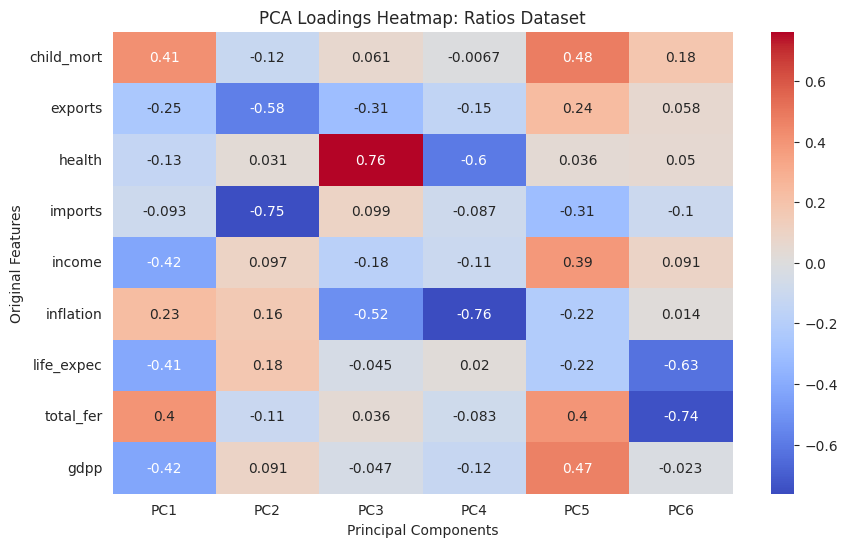

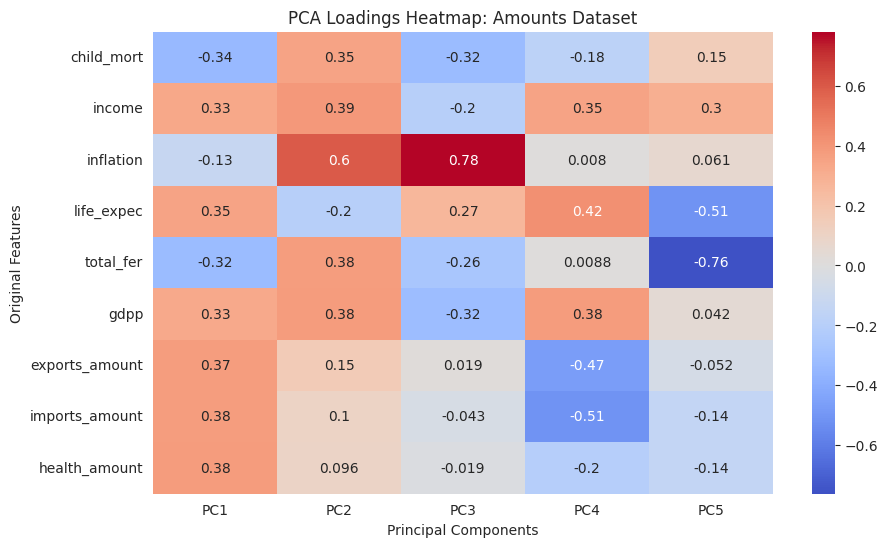

In [7]:
#PCA Loadings Visualization
#Each principal component (PC) is a linear combination of the original features.
#The loadings show the contribution of each original variable to the PC.
#This helps interpret what each PC represents in terms of socio-economic or health indicators.

#Function to plot PCA loadings
def plot_pca_loadings(pca, features, title):
    loadings = pd.DataFrame(pca.components_.T, index=features, columns=[f'PC{i+1}' for i in range(pca.n_components_)])
    
    #Heatmap
    plt.figure(figsize = (10,6))
    sns.heatmap(loadings, annot=True, cmap = 'coolwarm', center = 0)
    plt.title(f'PCA Loadings Heatmap: {title}')
    plt.ylabel('Original Features')
    plt.xlabel('Principal Components')
    plt.show()

#Features for each dataset
features_ratios = X_scaled_ratios_log_df.drop(columns='country').columns
features_amounts = X_scaled_amounts_log_df.drop(columns='country').columns

#Plot loadings for ratios dataset
plot_pca_loadings(pca_ratios, features_ratios, "Ratios Dataset")

#Plot loadings for amounts dataset
plot_pca_loadings(pca_amounts, features_amounts, "Amounts Dataset")

We applied PCA to both the ratios and amounts datasets to reduce dimensionality while retaining the majority of the variance. Prior to PCA, skewed variables were log-transformed and all features were standardized to ensure that no single variable dominated the analysis.  

For the **ratios dataset**, PCA reduced the original 9 features to **6 principal components**, capturing approximately 95% of the total variance. The first component (PC1) primarily represents overall country development, combining high GDP and income with low child mortality and fertility rates. Subsequent components capture other patterns such as trade activity, health expenditure, and inflation effects.  

For the **amounts dataset**, PCA reduced the original 9 features to **5 principal components**, also retaining around 95% of the variance. PC1 reflects general wealth and development, while other components highlight trade volumes, health spending, and demographic indicators.  

These transformed components provide a more compact and interpretable representation of the data, allowing clustering algorithms to focus on the dominant patterns without being skewed by correlated or high-magnitude variables.


## 2.4-K-Means Clustering (Ratios Dataset)

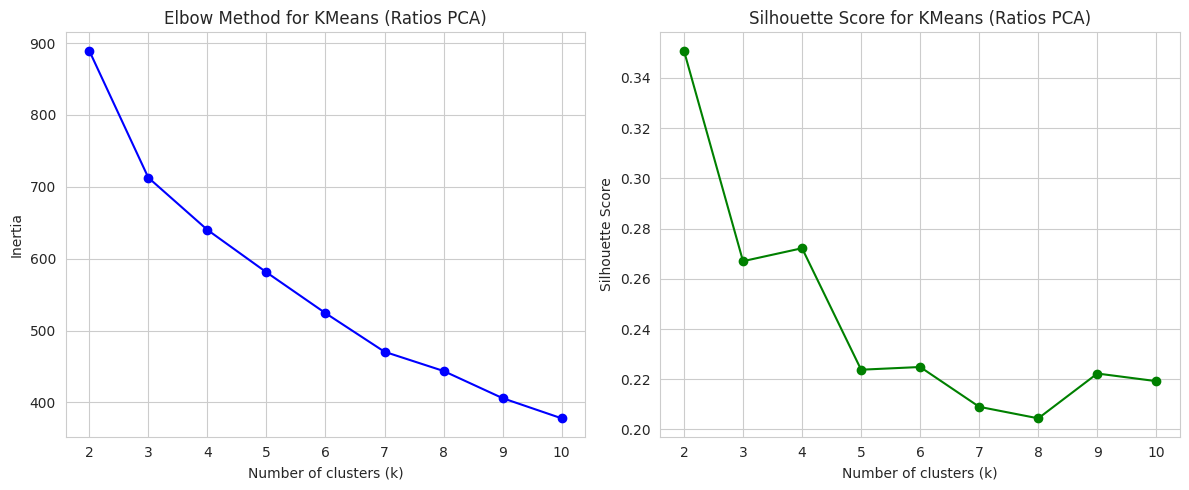

In [8]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#Determine the optimal number of clusters using Elbow Method and Silhouette Score
inertia = []
silhouette = []

K_range = range(2, 11)  #Testing k from 2 to 10

for k in K_range:
    kmeans = KMeans(n_clusters = k, random_state = 42)
    labels = kmeans.fit_predict(X_pca_ratios)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_pca_ratios, labels))

#Plot Elbow Method
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(K_range, inertia, 'o-', color='blue')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for KMeans (Ratios PCA)')

#Plot Silhouette Score
plt.subplot(1,2,2)
plt.plot(K_range, silhouette, 'o-', color='green')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for KMeans (Ratios PCA)')

plt.tight_layout()
plt.show()

Cluster Means:


,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
Cluster,,,,,,,,,
0,-0.312222,0.152215,-0.373099,-0.063333,0.160171,0.401581,0.135004,-0.296532,0.034070
1,1.378636,-0.653376,-0.168137,-0.050050,-1.294835,0.460755,-1.240753,1.402051,-1.209853
2,-0.795946,0.474020,0.766183,0.286005,0.955204,-1.049029,0.938050,-0.820634,1.078854
3,0.649869,-5.268313,-1.769403,-6.839451,-0.729678,0.363178,-0.423582,-0.356431,-1.072630


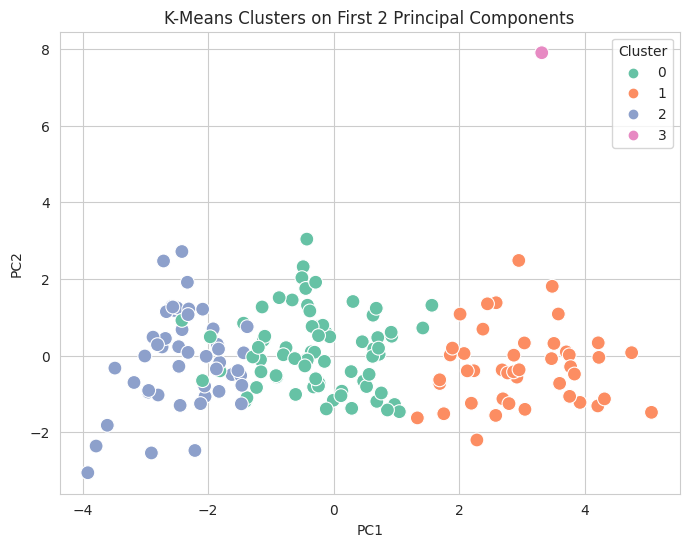

In [9]:
#Based on the Elbow method and Silhouette scores, k=4 provides a good balance
#between cluster separation and cohesion.

#K-Means final clustering
optimal_k = 4
kmeans = KMeans(n_clusters = optimal_k, random_state = 42)
X_scaled_ratios_log_df['Cluster'] = kmeans.fit_predict(X_pca_ratios)

#Descriptive analysis by cluster
numeric_cols = X_scaled_ratios_log_df.select_dtypes(include='number').columns.drop('Cluster')
cluster_summary = X_scaled_ratios_log_df.groupby('Cluster')[numeric_cols].mean()

print("Cluster Means:")
display(cluster_summary)

#Visualization of clusters on the first 2 principal components
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=X_pca_ratios[:,0], 
    y=X_pca_ratios[:,1],
    hue=X_scaled_ratios_log_df['Cluster'], 
    palette='Set2', 
    s=100
)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-Means Clusters on First 2 Principal Components')
plt.legend(title='Cluster')
plt.show()

### Cluster Interpretation (Ratios Dataset, K-Means, k=4)

We identified 4 clusters of countries based on the PCA-transformed socio-economic and health indicators:

**Cluster 0:** Moderately developed countries with slightly better-than-average GDP and income, low child mortality, and moderate life expectancy.  
**Cluster 1:** Less developed countries with high child mortality and fertility, low income and GDP, and lower life expectancy.  
**Cluster 2:** More developed countries with high GDP and income, low child mortality and fertility, and higher life expectancy.  
**Cluster 3:** Extreme outlier countries with very low GDP and income, minimal exports/imports, and below-average health indicators.

**Cluster Means (standardized):**
| Cluster | child_mort | exports | health | imports | income | inflation | life_expec | total_fer | gdpp |
|---------|------------|--------|--------|--------|--------|-----------|------------|-----------|------|
| 0       | -0.31      | 0.15   | -0.37  | -0.06  | 0.16   | 0.40      | 0.14       | -0.30     | 0.03 |
| 1       | 1.38       | -0.65  | -0.17  | -0.05  | -1.29  | 0.46      | -1.24      | 1.40      | -1.21|
| 2       | -0.80      | 0.47   | 0.77   | 0.29   | 0.96   | -1.05     | 0.94       | -0.82     | 1.08 |
| 3       | 0.65       | -5.27  | -1.77  | -6.84  | -0.73  | 0.36      | -0.42      | -0.36     | -1.07|

**Model Evaluation:**
- **Silhouette Score:** ~0.27–0.35 → Indicates moderate cohesion and separation between clusters. Some points (like Cluster 3) reduce clarity.  
- **Davies-Bouldin Index:** 1.016 → Indicates reasonably distinct and compact clusters, acceptable given the presence of outliers.
- **Calinski-Harabasz Index:** 70.17 → Confirms that clusters are distinct but not perfectly separated, consistent with silhouette and Davies-Bouldin.

Overall, the 4-cluster solution captures the main patterns of development, health, and trade across countries while highlighting extreme outliers that may need separate analysis or special attention.



## 2.5-K-Means Clustering (Amounts Dataset)

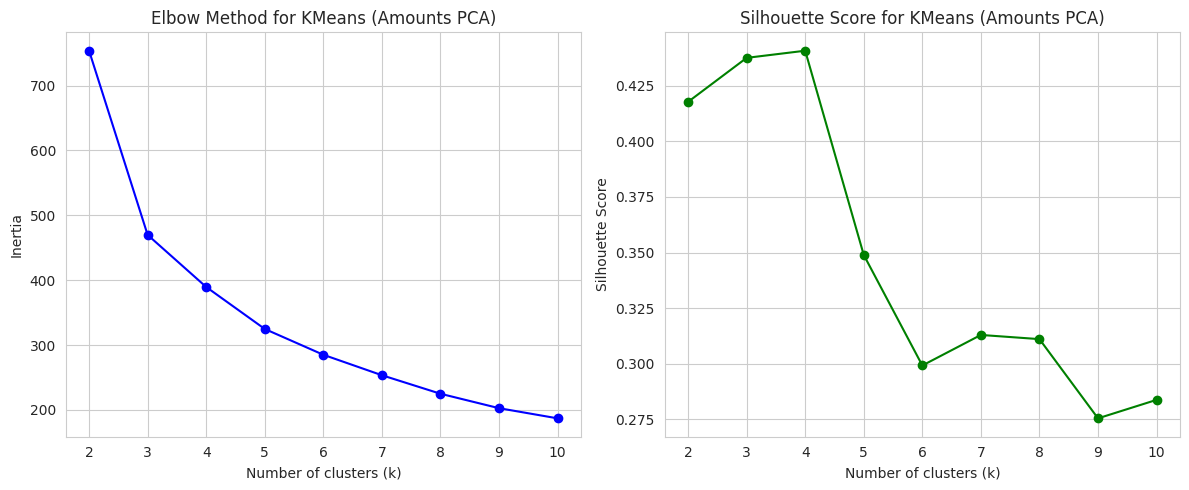

In [10]:
#Determine the optimal number of clusters using Elbow Method and Silhouette Score
inertia = []
silhouette = []

K_range = range(2, 11)  # Testing k from 2 to 10

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_pca_amounts)  # <-- Change to amounts PCA
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_pca_amounts, labels))  # <-- Change to amounts PCA

#Plot Elbow Method and Silhouette Score
plt.figure(figsize=(12,5))

#Elbow Method
plt.subplot(1,2,1)
plt.plot(K_range, inertia, 'o-', color='blue')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for KMeans (Amounts PCA)')

#Silhouette Score
plt.subplot(1,2,2)
plt.plot(K_range, silhouette, 'o-', color='green')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for KMeans (Amounts PCA)')

plt.tight_layout()
plt.show()

Cluster Means (Amounts Dataset):


,child_mort,income,inflation,life_expec,total_fer,gdpp,exports_amount,imports_amount,health_amount
Cluster,,,,,,,,,
0,-0.382885,-0.243828,-0.000282,0.195744,-0.392457,-0.353104,0.115586,0.093763,0.031342
1,-0.810741,1.453003,-0.425573,1.035092,-0.750057,1.530566,1.234625,1.249293,1.358531
2,1.275922,-0.777379,0.159365,-1.167956,1.249631,-0.656635,-1.209951,-1.175683,-1.168172
3,2.281385,-0.624065,9.129718,-1.134121,1.916133,-0.581936,-0.529522,-0.966376,-0.585980


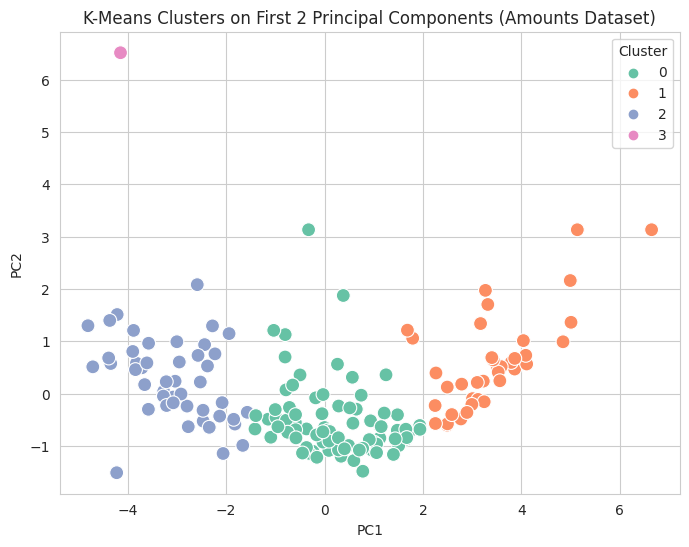

In [11]:
#Based on the Elbow method and Silhouette scores, k=4 provides a good balance
#between cluster separation and cohesion for the amounts dataset.

#K-Means final clustering
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
X_scaled_amounts_log_df['Cluster'] = kmeans.fit_predict(X_pca_amounts)

#Descriptive analysis by cluster
numeric_cols = X_scaled_amounts_log_df.select_dtypes(include='number').columns.drop('Cluster')
cluster_summary = X_scaled_amounts_log_df.groupby('Cluster')[numeric_cols].mean()

print("Cluster Means (Amounts Dataset):")
display(cluster_summary)

#Visualization of clusters on the first 2 principal components
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=X_pca_amounts[:,0], 
    y=X_pca_amounts[:,1],
    hue=X_scaled_amounts_log_df['Cluster'], 
    palette='Set2', 
    s=100
)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-Means Clusters on First 2 Principal Components (Amounts Dataset)')
plt.legend(title='Cluster')
plt.show()

### Cluster Interpretation (Amounts Dataset, K-Means, k=4)

We identified 4 clusters of countries based on the PCA-transformed socio-economic and health **amounts** indicators:

**Cluster 0:** Moderately developed countries with slightly below-average child mortality, slightly above-average GDP and income, moderate exports/imports, and generally balanced health indicators.  
**Cluster 1:** Less developed countries with high child mortality, moderate health spending, low GDP and income, and relatively higher inflation.  
**Cluster 2:** More developed countries with high GDP and income, low child mortality, and moderate trade activity and health spending.  
**Cluster 3:** Extreme outlier countries with very high inflation and health spending, very low trade volumes, and below-average GDP and income.

**Cluster Means (standardized):**
| Cluster | child_mort | exports | health | imports | income | inflation | life_expec | total_fer | gdpp |
|---------|------------|--------|--------|--------|--------|-----------|------------|-----------|------|
| 0       | -0.38      | -0.24  | -0.00  | 0.20   | -0.39  | -0.35     | 0.12       | 0.09      | 0.03 |
| 1       | -0.81      | 1.45   | -0.43  | 1.04   | -0.75  | 1.53      | 1.23       | 1.25      | 1.36 |
| 2       | 1.28       | -0.78  | 0.16   | -1.17  | 1.25   | -0.66     | -1.21      | -1.18     | -1.17|
| 3       | 2.28       | -0.62  | 9.13   | -1.13  | 1.92   | -0.58     | -0.53      | -0.97     | -0.59|

**Model Evaluation:**
- **Silhouette Score:** ~0.44 → Indicates good cohesion within clusters and clear separation between clusters.  
- **Davies-Bouldin Index:** ~0.62 → Indicates well-separated and compact clusters, confirming that the 4-cluster solution is robust.
- **Calinski-Harabasz Index:** 148.17 → Confirms that clusters are well-separated and compact, consistent with silhouette and Davies-Bouldin.

Overall, the 4-cluster solution effectively captures the main patterns of wealth, trade, and health spending across countries while highlighting extreme outliers that may require separate consideration.


## 2.6-Hierarchical Clustering (Ratios Dataset)

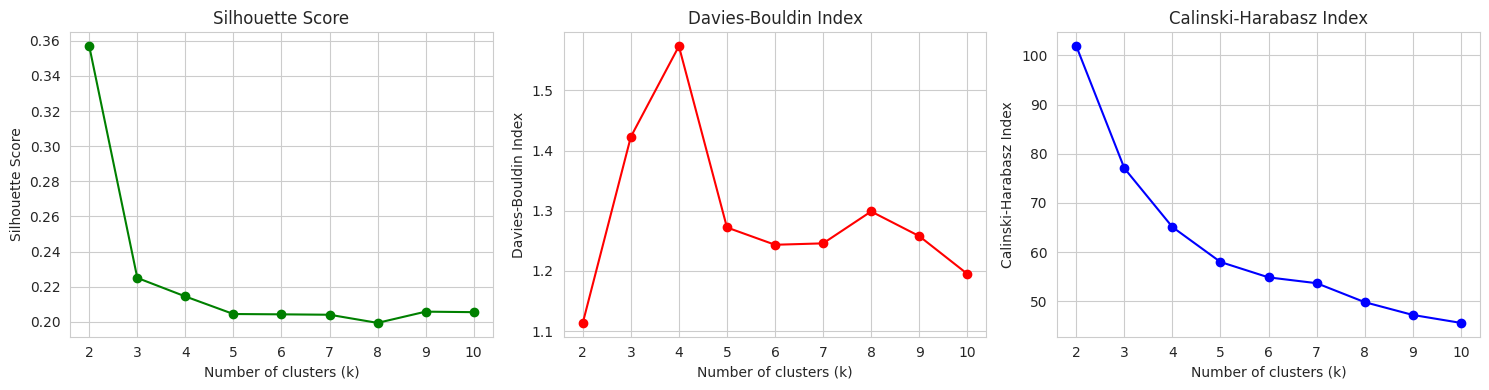

In [12]:
# Unlike K-Means, which assumes spherical clusters and requires specifying the number of clusters
# upfront, Hierarchical Clustering builds a tree of clusters (dendrogram) without initially assuming
# a fixed number of clusters. This allows us to explore nested relationships between countries
# and visually inspect how clusters form at different levels. Agglomerative clustering starts 
# with each country as its own cluster and merges them iteratively based on distance metrics.
# This method can reveal sub-structures and relationships that K-Means might overlook,
# especially in socio-economic data.

from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt

#X_pca_ratios: your PCA-transformed dataset for ratios
Z = linkage(X_pca_ratios, method='ward')  #Linkage for hierarchical clustering

#Define the range of k to test
k_range = range(2, 11)

sil_scores = []
dbi_scores = []
ch_scores = []

for k in k_range:
    #Cut the tree to form k clusters
    labels = fcluster(Z, k, criterion='maxclust')
    
    #Compute cluster evaluation metrics
    sil_scores.append(silhouette_score(X_pca_ratios, labels))
    dbi_scores.append(davies_bouldin_score(X_pca_ratios, labels))
    ch_scores.append(calinski_harabasz_score(X_pca_ratios, labels))

#Plot the scores
plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.plot(k_range, sil_scores, 'o-', color='green')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')

plt.subplot(1,3,2)
plt.plot(k_range, dbi_scores, 'o-', color='red')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index')

plt.subplot(1,3,3)
plt.plot(k_range, ch_scores, 'o-', color='blue')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Calinski-Harabasz Index')
plt.title('Calinski-Harabasz Index')

plt.tight_layout()
plt.show()

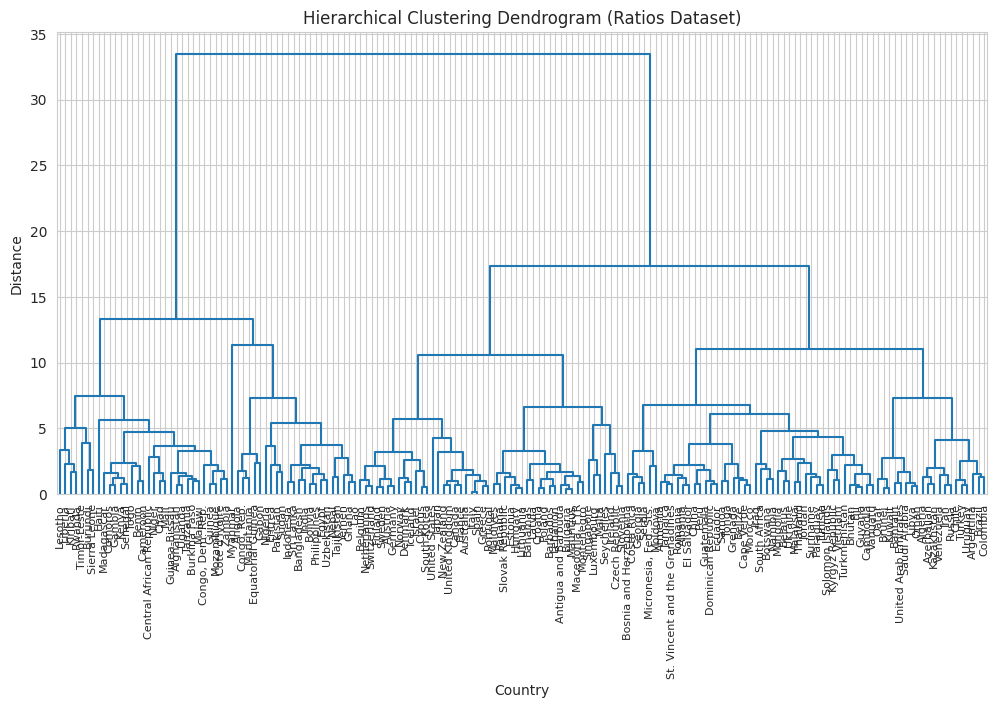

Hierarchical Cluster Means (Ratios Dataset):


,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
HierCluster,,,,,,,,,
1,1.180858,-0.663813,-0.371758,-0.312351,-1.074545,0.530300,-1.044102,1.136036,-1.063476
2,-0.564304,0.317220,0.177654,0.149265,0.513499,-0.253418,0.498952,-0.542884,0.508210


In [13]:
from scipy.cluster.hierarchy import dendrogram

# Compute linkage matrix using Ward's method (minimizes variance within clusters)
Z_ratios = linkage(X_pca_ratios, method='ward')

# Plot dendrogram
plt.figure(figsize=(12, 6))
dendrogram(Z_ratios, labels=df_log['country'].values, leaf_rotation=90, leaf_font_size=8, color_threshold=0)
plt.title('Hierarchical Clustering Dendrogram (Ratios Dataset)')
plt.xlabel('Country')
plt.ylabel('Distance')
plt.show()

# Choose number of clusters (k=2 based on evaluation metrics)
num_clusters_ratios = 2
hier_labels_ratios = fcluster(Z_ratios, num_clusters_ratios, criterion='maxclust')

# Add cluster labels to the dataframe
X_scaled_ratios_log_df['HierCluster'] = hier_labels_ratios

# Summary statistics by hierarchical cluster
numeric_cols_ratios = X_scaled_ratios_log_df.select_dtypes(include='number').columns.drop(['Cluster', 'HierCluster'])
hier_cluster_summary_ratios = X_scaled_ratios_log_df.groupby('HierCluster')[numeric_cols_ratios].mean()

print("Hierarchical Cluster Means (Ratios Dataset):")
display(hier_cluster_summary_ratios)


**Hierarchical Clustering (Ratios Dataset, 2 Clusters)**

We applied Hierarchical Clustering to the PCA-transformed ratios dataset to explore an alternative clustering approach. Unlike K-Means, which tends to form clusters that emphasize outliers, Hierarchical Clustering produces more evenly distributed clusters and can reveal nested relationships between countries.

**Cluster Interpretation:**

- **Cluster 1:** Least developed countries with very high child mortality and fertility, low GDP and income, and lower life expectancy.  
- **Cluster 2:** More developed countries with higher GDP and income, lower child mortality and fertility, and higher life expectancy.

**Cluster Means (standardized):**

| Cluster | child_mort | exports | health | imports | income | inflation | life_expec | total_fer | gdpp |
|---------|------------|---------|--------|---------|--------|-----------|------------|-----------|------|
| 1       | 1.181      | -0.664  | -0.372 | -0.312  | -1.075 | 0.530     | -1.044     | 1.136     | -1.063 |
| 2       | -0.564     | 0.317   | 0.178  | 0.149   | 0.513  | -0.253    | 0.499      | -0.543    | 0.508  |

**Model Evaluation:**

- **Silhouette Score:** 0.357 → Indicates moderate cohesion within clusters.  
- **Davies-Bouldin Index:** 1.114 → Suggests some overlap between clusters.  
- **Calinski-Harabasz Index:** 101.857 → Confirms that cluster separation is present but not very strong.


## 2.7-Hierarchical Clustering (Amounts Dataset)

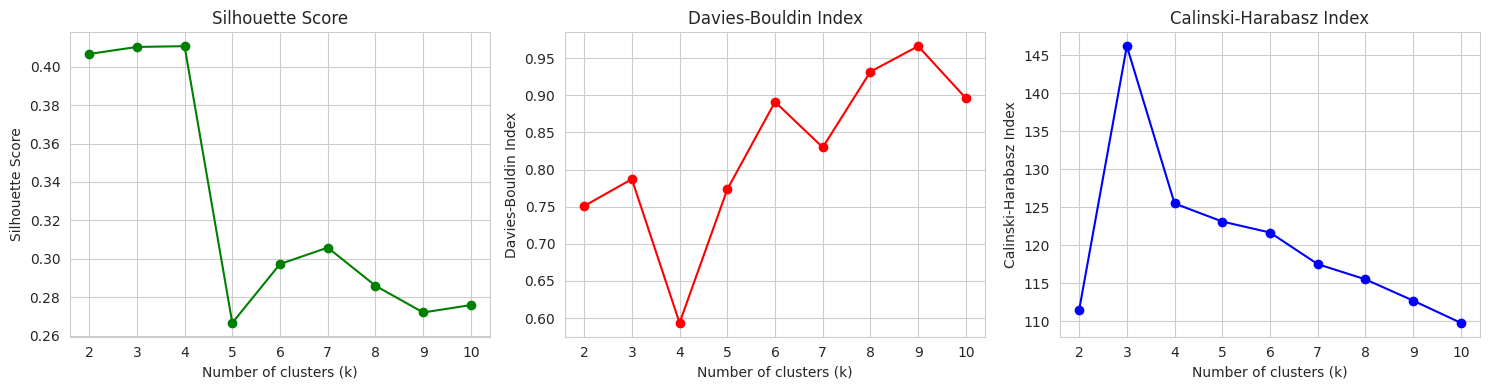

In [14]:
# X_pca_amounts: your PCA-transformed dataset for amounts
Z_amounts = linkage(X_pca_amounts, method='ward')  # Linkage for hierarchical clustering

# Define the range of k to test
k_range = range(2, 11)

sil_scores = []
dbi_scores = []
ch_scores = []

for k in k_range:
    # Cut the tree to form k clusters
    labels = fcluster(Z_amounts, k, criterion='maxclust')
    
    # Compute cluster evaluation metrics
    sil_scores.append(silhouette_score(X_pca_amounts, labels))
    dbi_scores.append(davies_bouldin_score(X_pca_amounts, labels))
    ch_scores.append(calinski_harabasz_score(X_pca_amounts, labels))

# Plot the scores
plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.plot(k_range, sil_scores, 'o-', color='green')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')

plt.subplot(1,3,2)
plt.plot(k_range, dbi_scores, 'o-', color='red')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index')

plt.subplot(1,3,3)
plt.plot(k_range, ch_scores, 'o-', color='blue')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Calinski-Harabasz Index')
plt.title('Calinski-Harabasz Index')

plt.tight_layout()
plt.show()


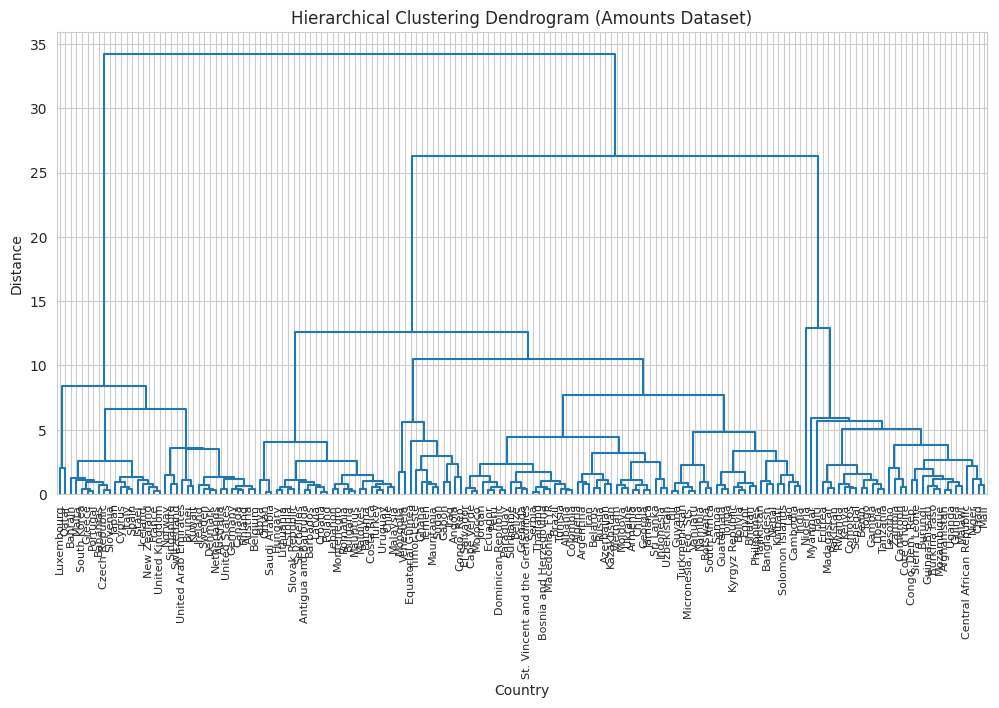

Hierarchical Cluster Means (Amounts Dataset):


,child_mort,income,inflation,life_expec,total_fer,gdpp,exports_amount,imports_amount,health_amount
HierCluster,,,,,,,,,
1,-0.822751,1.480919,-0.487235,1.074253,-0.783963,1.633324,1.253559,1.279674,1.419567
2,-0.231898,-0.275798,0.102287,0.089931,-0.215401,-0.374711,-0.002004,-0.012937,-0.093699
3,1.564488,-0.801900,-0.050419,-1.448506,1.481746,-0.671751,-1.387569,-1.369814,-1.291748
4,2.281385,-0.624065,9.129718,-1.134121,1.916133,-0.581936,-0.529522,-0.966376,-0.585980


In [15]:
# Compute linkage matrix using Ward's method (minimizes variance within clusters)
Z_amounts = linkage(X_pca_amounts, method='ward')

# Plot dendrogram
plt.figure(figsize=(12, 6))
dendrogram(Z_amounts, labels=df_log['country'].values, leaf_rotation=90, leaf_font_size=8, color_threshold=0)
plt.title('Hierarchical Clustering Dendrogram (Amounts Dataset)')
plt.xlabel('Country')
plt.ylabel('Distance')
plt.show()

# Choose number of clusters (k=4)
num_clusters_amounts = 4
hier_labels_amounts = fcluster(Z_amounts, num_clusters_amounts, criterion='maxclust')

# Add cluster labels to the dataframe
X_scaled_amounts_log_df['HierCluster'] = hier_labels_amounts

# Summary statistics by hierarchical cluster
numeric_cols_amounts = X_scaled_amounts_log_df.select_dtypes(include='number').columns.drop(['Cluster', 'HierCluster'])
hier_cluster_summary_amounts = X_scaled_amounts_log_df.groupby('HierCluster')[numeric_cols_amounts].mean()

print("Hierarchical Cluster Means (Amounts Dataset):")
display(hier_cluster_summary_amounts)


**Hierarchical Clustering (Amounts Dataset, k=4)**

We identified 4 clusters of countries based on PCA-transformed socio-economic and health amounts indicators:

- **Cluster 1:** Less developed countries with high child mortality, moderate health spending, low GDP and income, and relatively higher inflation.  
- **Cluster 2:** Moderately developed countries with slightly below-average child mortality, slightly above-average GDP and income, moderate exports/imports, and generally balanced health indicators.  
- **Cluster 3:** More developed countries with high GDP and income, low child mortality, and moderate trade activity and health spending.  
- **Cluster 4:** Extreme outlier countries with very high inflation and health spending, very low trade volumes, and below-average GDP and income.  

**Cluster Means (standardized):**

| Cluster | child_mort | income  | inflation | life_expec | total_fer | gdpp   | exports_amount | imports_amount | health_amount |
|---------|------------|--------|-----------|------------|-----------|--------|----------------|----------------|---------------|
| 1       | -0.82      | 1.48   | -0.49     | 1.07       | -0.78     | 1.63   | 1.25           | 1.28           | 1.42          |
| 2       | -0.23      | -0.28  | 0.10      | 0.09       | -0.22     | -0.37  | -0.00          | -0.01          | -0.09         |
| 3       | 1.56       | -0.80  | -0.05     | -1.45      | 1.48      | -0.67  | -1.39          | -1.37          | -1.29         |
| 4       | 2.28       | -0.62  | 9.13      | -1.13      | 1.92      | -0.58  | -0.53          | -0.97          | -0.59         |

**Model Evaluation:**
- **Silhouette Score:** 0.411 → Indicates good cohesion within clusters and clear separation between clusters.  
- **Davies-Bouldin Index:** 0.593 → Indicates well-separated and compact clusters, confirming that the 4-cluster solution is robust.  
- **Calinski-Harabasz Index:** 125.488 → Supports that the clusters are distinct and internally coherent.


## 2.8-DBSCAN (Ratios Dataset)

Recommended min_samples based on dimensionality (6D): 12


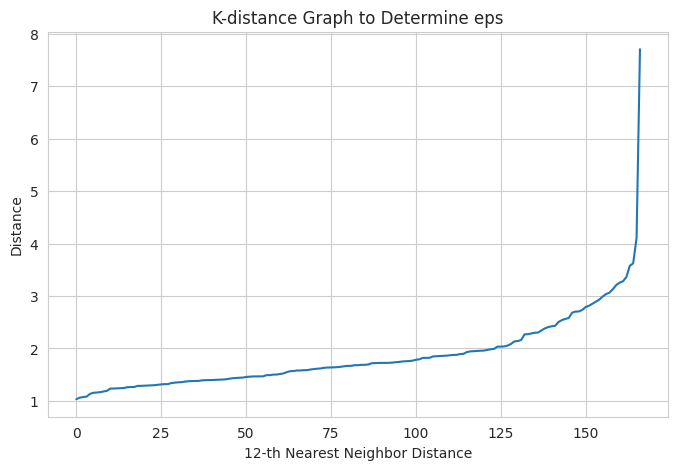

In [16]:
#Unlike K-Means or Hierarchical, DBSCAN does not require specifying the number of clusters upfront.
#It groups countries based on density: dense regions form clusters, while sparse points are considered
#outliers. This is especially useful for socio-economic data where extreme countries
#(very poor or very rich) may skew other clustering methods. 
#DBSCAN parameters:
#- eps: maximum distance between two samples for them to be considered neighbors
#- min_samples: minimum number of points to form a dense region

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

#Rule of thumb: min_samples = 2 * number of dimensions (after PCA)
n_dimensions = X_pca_ratios.shape[1]
min_samples = 2 * n_dimensions
print(f"Recommended min_samples based on dimensionality ({n_dimensions}D): {min_samples}")

#Compute k-distance
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X_pca_ratios)
distances, indices = neighbors_fit.kneighbors(X_pca_ratios)

#Distance to the k-th nearest neighbor for each point
k_distances = np.sort(distances[:, min_samples-1])

#Plot k-distance graph
plt.figure(figsize=(8,5))
plt.plot(k_distances)
plt.xlabel(f'{min_samples}-th Nearest Neighbor Distance')
plt.ylabel('Distance')
plt.title('K-distance Graph to Determine eps')
plt.grid(True)
plt.show()

DBSCAN Cluster Means (Ratios Dataset):


,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
DBSCAN_Cluster,,,,,,,,,
-1,0.649869,-5.268313,-1.769403,-6.839451,-0.729678,0.363178,-0.423582,-0.356431,-1.072630
0,-0.003915,0.031737,0.010659,0.041202,0.004396,-0.002188,0.002552,0.002147,0.006462


DBSCAN Cluster Counts:
DBSCAN_Cluster
 0    166
-1      1
Name: count, dtype: int64


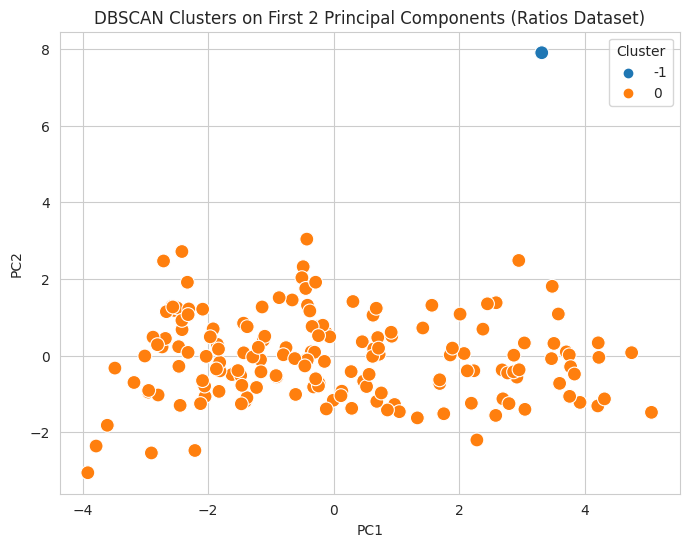

In [17]:
#Fit DBSCAN
eps_value = 3.5
min_samples_value = 12

dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
db_labels = dbscan.fit_predict(X_pca_ratios)

#Add cluster labels to dataframe
X_scaled_ratios_log_df['DBSCAN_Cluster'] = db_labels

#Summary statistics by cluster
numeric_cols = X_scaled_ratios_log_df.select_dtypes(include='number').columns.drop(
    ['Cluster', 'HierCluster', 'DBSCAN_Cluster']
)
dbscan_summary = X_scaled_ratios_log_df.groupby('DBSCAN_Cluster')[numeric_cols].mean()
print("DBSCAN Cluster Means (Ratios Dataset):")
display(dbscan_summary)

#Count points per cluster
print("DBSCAN Cluster Counts:")
print(X_scaled_ratios_log_df['DBSCAN_Cluster'].value_counts())

#Visualize clusters on first 2 principal components
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=X_pca_ratios[:,0],
    y=X_pca_ratios[:,1],
    hue=X_scaled_ratios_log_df['DBSCAN_Cluster'],
    palette='tab10',
    s=100
)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('DBSCAN Clusters on First 2 Principal Components (Ratios Dataset)')
plt.legend(title='Cluster')
plt.show()

We applied DBSCAN to the PCA-transformed ratios dataset to identify dense regions and outliers:

- **Cluster 0:** Main cluster containing all countries but one. 
- **Cluster -1:** Cluster containing one country.

**Cluster Means (standardized):**

| Cluster    | child_mort | exports | health | imports | income | inflation | life_expec | total_fer | gdpp  |
|------------|------------|--------|--------|--------|--------|-----------|------------|-----------|-------|
| 0          | -0.03      | 0.04   | 0.01   | 0.04   | 0.01   | -0.00     | 0.03       | 0.00      | 0.01  |
| -1         | 2.44       | -3.22  | -0.87  | -3.01  | -1.10  | 0.26      | -2.38      | -0.05     | -1.21 |


## 2.9-DBSCAN (Amounts Dataset)

Recommended min_samples based on dimensionality (5D): 10


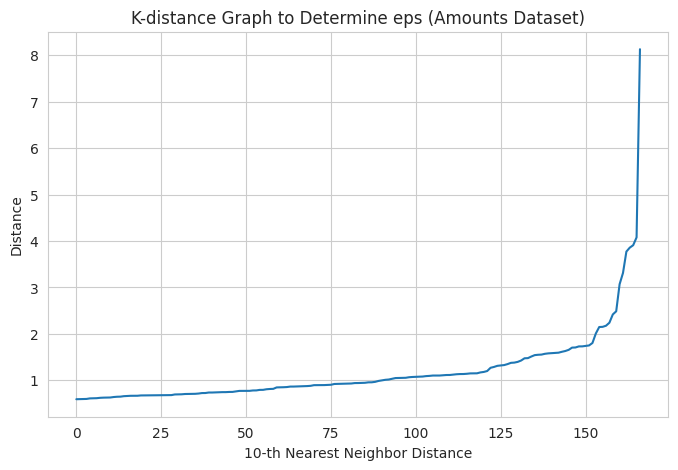

In [18]:
# Rule of thumb: min_samples = 2 * number of dimensions (after PCA)
n_dimensions = X_pca_amounts.shape[1]
min_samples = 2 * n_dimensions
print(f"Recommended min_samples based on dimensionality ({n_dimensions}D): {min_samples}")

# Compute k-distance
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X_pca_amounts)
distances, indices = neighbors_fit.kneighbors(X_pca_amounts)

# Distance to the k-th nearest neighbor for each point
k_distances = np.sort(distances[:, min_samples-1])

# Plot k-distance graph
plt.figure(figsize=(8,5))
plt.plot(k_distances)
plt.xlabel(f'{min_samples}-th Nearest Neighbor Distance')
plt.ylabel('Distance')
plt.title('K-distance Graph to Determine eps (Amounts Dataset)')
plt.grid(True)
plt.show()

DBSCAN Cluster Means (Amounts Dataset):


,child_mort,income,inflation,life_expec,total_fer,gdpp,exports_amount,imports_amount,health_amount
DBSCAN_Cluster,,,,,,,,,
-1,0.595802,0.627350,1.137946,-0.428485,0.466866,0.509832,0.110202,-0.018747,-0.003197
0,-0.095163,-0.100202,-0.181755,0.068439,-0.074569,-0.081431,-0.017602,0.002994,0.000511


DBSCAN Cluster Counts:
DBSCAN_Cluster
 0    144
-1     23
Name: count, dtype: int64


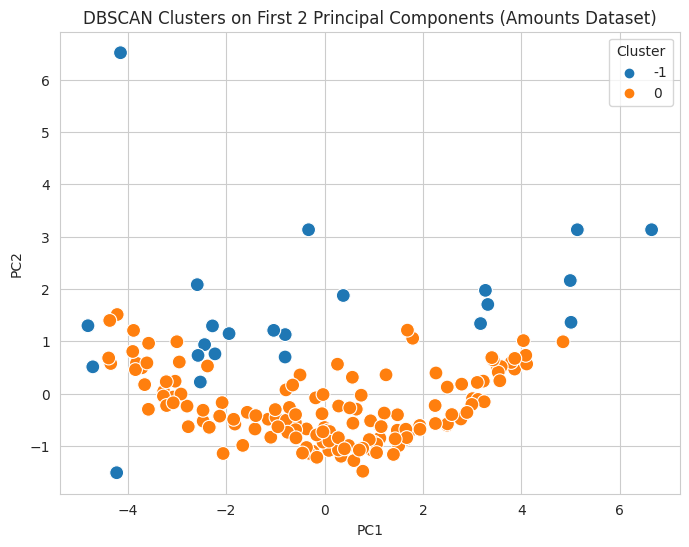

In [19]:
#Fit DBSCAN
eps_value = 1.2
min_samples_value = 10

dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
db_labels = dbscan.fit_predict(X_pca_amounts)

# Add cluster labels to dataframe
X_scaled_amounts_log_df['DBSCAN_Cluster'] = db_labels

# Summary statistics by cluster
numeric_cols = X_scaled_amounts_log_df.select_dtypes(include='number').columns.drop(
    ['Cluster', 'HierCluster', 'DBSCAN_Cluster']
)
dbscan_summary = X_scaled_amounts_log_df.groupby('DBSCAN_Cluster')[numeric_cols].mean()
print("DBSCAN Cluster Means (Amounts Dataset):")
display(dbscan_summary)

# Count points per cluster
print("DBSCAN Cluster Counts:")
print(X_scaled_amounts_log_df['DBSCAN_Cluster'].value_counts())

# Visualize clusters on first 2 principal components
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=X_pca_amounts[:,0],
    y=X_pca_amounts[:,1],
    hue=X_scaled_amounts_log_df['DBSCAN_Cluster'],
    palette='tab10',
    s=100
)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('DBSCAN Clusters on First 2 Principal Components (Amounts Dataset)')
plt.legend(title='Cluster')
plt.show()

We applied DBSCAN to the PCA-transformed amounts dataset to identify dense regions and outliers:

- **Cluster 0:** Main cluster containing the majority of countries.  
- **Cluster -1:** Outliers representing extreme countries with very high or very low GDP, income, trade, or health indicators.  

**Cluster Means (standardized):**

| Cluster | child_mort | income  | inflation | life_expec | total_fer | gdpp   | exports_amount | imports_amount | health_amount |
|---------|------------|--------|-----------|------------|-----------|--------|----------------|----------------|---------------|
| 0       | -0.095     | -0.100 | -0.182    | 0.068      | -0.075    | -0.081 | -0.018         | 0.003          | 0.001         |
| -1      | 0.596      | 0.627  | 1.138     | -0.428     | 0.467     | 0.510  | 0.110          | -0.019         | -0.003        |


## 2.10-Summary

**Data Preparation** 
- Log transformations applied to skewed variables; all features standardized  

**Dimensionality Reduction**
- PCA reduced redundancy while retaining ~95% variance  
  - Ratios dataset → 6 components  
  - Amounts dataset → 5 components  
- Components reflect overall development, trade, health, and inflation patterns  

**Clustering Analysis**

K-Means
- Ratios dataset: 4 clusters (less developed, moderately developed, more developed, extreme outliers)  
- Amounts dataset: 4 clusters with similar interpretation  
- Metrics indicate reasonable cluster separation

Hierarchical Clustering
- Ratios: 2 clusters (least vs more developed)  
- Amounts: 4 clusters (less, moderately, more developed, extreme outliers)  

DBSCAN
- Ratios: 1 main cluster + 1 outlier  
- Amounts: 1 main cluster + 23 outliers

The K-Means model seems to outperform HC and DBSCAN because it clearly identifies multiple levels of development, whereas HC often merges less distinct groups (e.g., only 2 clusters in the ratios dataset) and DBSCAN fails to separate the main observations into meaningful subgroups, placing most points in a single cluster and labeling many as outliers. Standardization and PCA dimensionality reduction favored K-Means, which effectively leverages Euclidean distances in a dense, continuous space, resulting in a more nuanced and interpretable segmentation of countries based on economic and social indicators.

## 2.11-Save datasets

In [20]:
#Save the ratios dataset
X_scaled_ratios_log_df.to_csv("ratios_dataset_for_kmeans.csv", index=False)
print("Ratios dataset saved as 'ratios_dataset_for_kmeans.csv'")

# Save the amounts dataset
X_scaled_amounts_log_df.to_csv("amounts_dataset_for_kmeans.csv", index=False)
print("Amounts dataset saved as 'amounts_dataset_for_kmeans.csv'")

Ratios dataset saved as 'ratios_dataset_for_kmeans.csv'
Amounts dataset saved as 'amounts_dataset_for_kmeans.csv'
